In [0]:
! yes | pip3 uninstall opencv-python
! yes | pip3 uninstall opencv-contrib-python
! yes | pip3 install opencv-python==3.4.2.16
! yes | pip3 install opencv-contrib-python==3.4.2.16


Uninstalling opencv-python-3.4.5.20:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-3.4.5.20.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-python-3.4.5.20
Uninstalling opencv-contrib-python-3.4.3.18:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-3.4.3.18.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-contrib-python-3.4.3.18
     |████████████████████████████████| 25.0MB 1.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6MB 1.3MB/s 


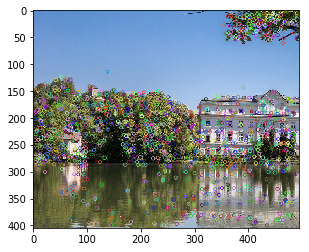

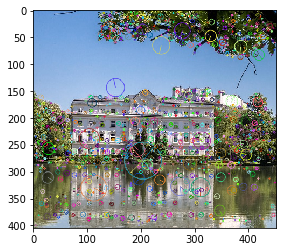

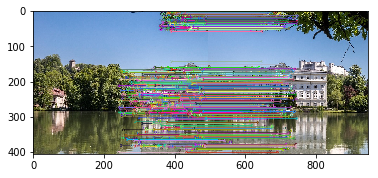

The number of Matched Line:  664


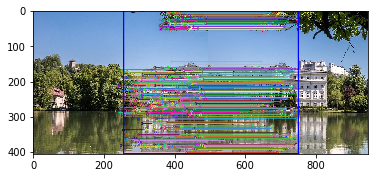

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#def download_DB():
#    ! curl -s 'https://raw.githubusercontent.com/sejong-rcv/VisualRecognition/blob/master/1%EC%A3%BC%EC%B0%A8-%EC%8B%A4%EC%8A%B5/data2/1.jpg' -o '1.jpg'
#    ! curl -s 'https://raw.githubusercontent.com/sejong-rcv/VisualRecognition/blob/master/1%EC%A3%BC%EC%B0%A8-%EC%8B%A4%EC%8A%B5/data2/2.jpg' -o '2.jpg'

def correspondence_problem(factor):

   
    img1 = cv2.imread('1.jpg')
    img2 = cv2.imread('2.jpg')

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    ## resize
    #img1 = cv2.resize(img1, dsize=(480, 640), interpolation=cv2.INTER_AREA)
    #img2 = cv2.resize(img2, dsize=(480, 640), interpolation=cv2.INTER_AREA)

    # sift 선언
    sift = cv2.xfeatures2d.SIFT_create()

    # SIFT 검출
    kp1 = sift.detect(img1_gray, None)
    kp2 = sift.detect(img2_gray, None)

    # SIFT 기술
    kp1, des1 = sift.compute(img1_gray, kp1)
    kp2, des2 = sift.compute(img2_gray, kp2)


    # FLANN 매칭
    FlANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FlANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    res = None
    good = []
    for m, n in matches:
        if m.distance < factor * n.distance:
            good.append(m)
    res = cv2.drawMatches(img1, kp1, img2, kp2, good, res, flags=2)

    # 이미지 출력
    img1_2, img2_2 = None, None
    img1_2 = cv2.drawKeypoints(img1, kp1, img1_2)
    img2_2 = cv2.drawKeypoints(img2, kp2, img2_2,
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #
    # cv2.imshow('SIFT1 detect', img1_2)
    # cv2.imshow('SIFT2 detect', img2_2)
    # cv2.imshow('Feature Matching', res)

    plt.imshow(cv2.cvtColor(img1_2, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(img2_2, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
    # homography to find objects
    MIN_MATCH_COUNT = 30
    print("The number of Matched Line: ", len(good))
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # We have seen that there can be some possible errors while matching which may affect the result.
        # To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags)
        matchesMask = mask.ravel().tolist()
        # ravel(): return a contiguous flattened array, tolist(): transfer tensor to list.

        h, w = img1.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        dst +=np.float32([w,0])
        dst = cv2.polylines(dst, [np.int32(dst)], True, 255, 2, cv2.LINE_AA)
        # 그릴 대상 이미지, pts[i]위치 배열의 포인트 수,마지막과 처음 포인트 연결
    else:
        print("not enough matches", len(good))
        matchesMask = None


    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask, flags=0)
    # img4 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

    # Draw bounding box in Red    
    img4 = cv2.polylines(res, [np.int32(dst)], True, (255, 0, 0), 2, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
    plt.show()

    
correspondence_problem(0.5)